# Fitting Models to Atmospheric $CO_2$ Levels 

In this notebook I will fit a model for the CO$_2$ data with the first 70-80% of the rows as training data, and the rest being test data. I will do this for both linear and quadratic models, and calculate respective R$^2$ and MSE values to determine which is the more suitable fit.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# load the data
training_data = np.load('../Data/CO2_training_data.npy') 
test_data = np.load('../Data/CO2_test_data.npy')
full_data = np.load('../Data/CO2_data_full.npy')

### Linear and quadratic fits, no periodic components yet:

- Print $\beta_{l0}$, $\beta_{l1}$, $\beta_{q0}$, $\beta_{q1}$, and $\beta_{q2}$
- Display plot showing scatter of raw data along with both linear and quadratic fit

In [2]:
# separate columns into x and y data
x_tr = training_data[:,0]
y_tr = training_data[:,1]

beta_l = np.polyfit(x_tr, y_tr, 1)[::-1]  # Beta vector for the linear fit (vector of polynomial coefficients)
beta_q = np.polyfit(x_tr, y_tr, 2)[::-1]  # Beta vector for the quadratic fit
print("\n\n\u03B2\u2097\u2080: ", np.round(beta_l[0], 3), "\t\t\u03B2\u2097\u2081: ", np.round(beta_l[1], 3))
print("\n\u03B2_q\u2080: ", np.round(beta_q[0], 3), "\t\u03B2_q\u2081: ", np.round(beta_q[1], 3), "\t\t\u03B2_q\u2082: ", np.round(beta_q[2], 3), "\n\n")





βₗ₀:  -2297.334 		βₗ₁:  1.332

β_q₀:  44578.808 	β_q₁:  -46.027 		β_q₂:  0.012 




These coefficients characterise the models, ie the linear model is given by $y = -2297.334 + 1.332x$, and the quadratic one by $y = 44578.808 - 46.027x + 0.012x^2$

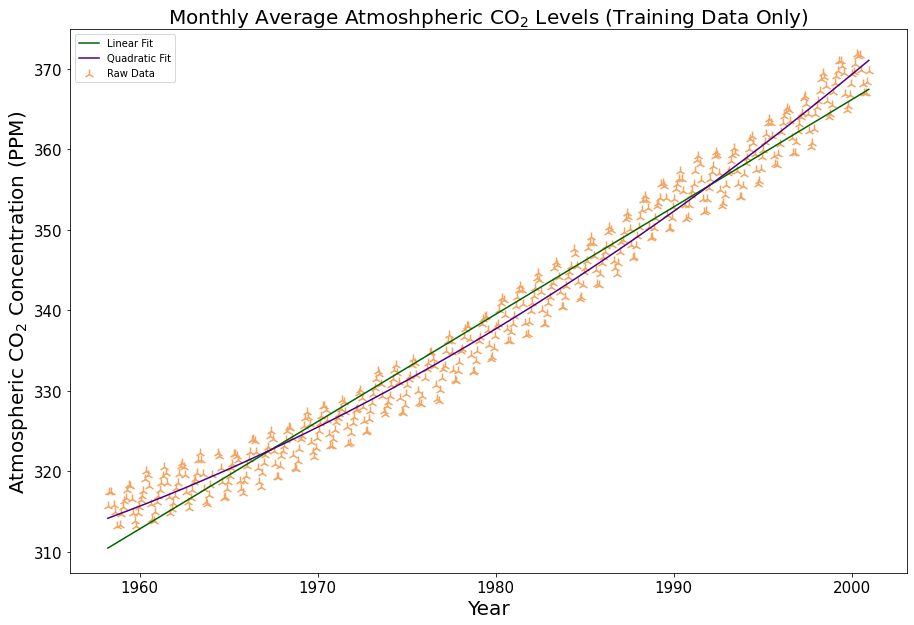

In [3]:
# Matrices with columns of x data raised to different powers
X_l = np.column_stack((tuple([x_tr**i for i in range(2)])))
X_q = np.column_stack((tuple([x_tr**i for i in range(3)])))

l_fit = X_l.dot(beta_l)  # Fits for each model
q_fit = X_q.dot(beta_q) 
l_res = y_tr - l_fit  # Residuals for each model
q_res = y_tr - q_fit

# graph size parameters
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

# plotting stuff
plt.scatter(x_tr, y_tr, s=100, marker="2", color='sandybrown', label='Raw Data')
plt.plot(x_tr, l_fit, color='darkgreen', label='Linear Fit')
plt.plot(x_tr, q_fit, color='indigo', label='Quadratic Fit')
plt.xlabel("Year")
plt.ylabel("Atmospheric CO$_2$ Concentration (PPM)")
plt.title("Monthly Average Atmoshpheric CO$_2$ Levels (Training Data Only)")
plt.legend()
plt.show()

### Fitting periodic models to the residuals of the linear and quadratic fits:

- Display scatterplots of residuals
- Compute and plot the periodogram of the residuals
- Identify frequencies for which periodogram value exceeds 50% of maximum, and then find & print linear regression coefficients corresponding to sinusoids of these frequencies
- Display scatterplots of residuals along with periodic models


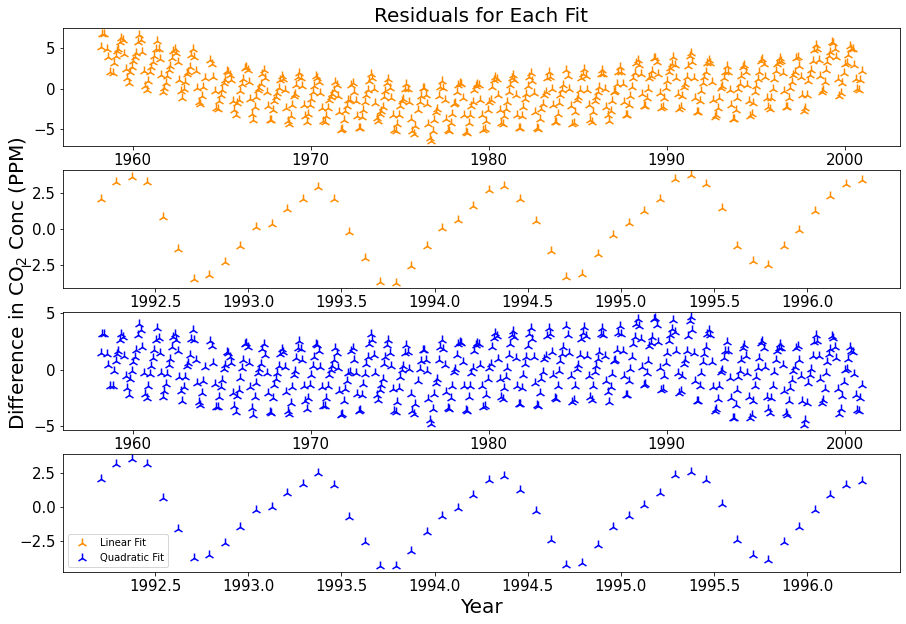

In [4]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

plt.subplot(411)
plt.title('Residuals for Each Fit')
top_scat = plt.scatter(x_tr, l_res, s=100, marker="2", color='darkorange', label='Linear Fit')
plt.subplot(412)
plt.scatter(x_tr[401:451], l_res[401:451], s=100, marker='2', color='darkorange') 
plt.subplot(413)
plt.ylabel('Difference in CO$_2$ Conc (PPM)', loc='bottom')
bot_scat = plt.scatter(x_tr, q_res, s=100, marker="2", color='blue', label='Quadratic Fit')
plt.subplot(414)
plt.legend(handles=[top_scat, bot_scat])
plt.scatter(x_tr[401:451], q_res[401:451], s=100, marker='2', color='blue')
plt.xlabel('Year')

plt.show()

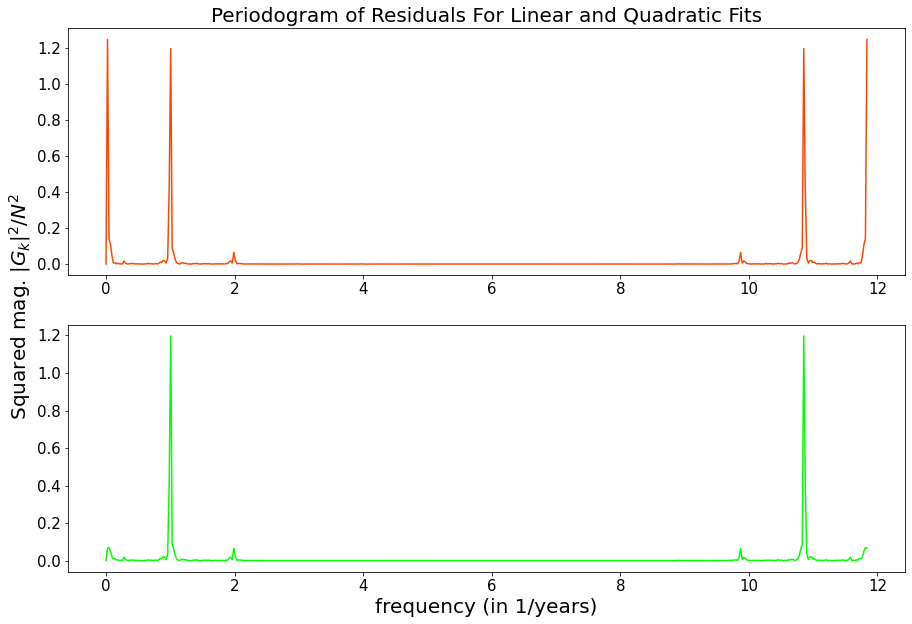

In [5]:
N = np.size(x_tr) # total number of data points
T = (x_tr[-1] - x_tr[0]) / N  # Data is monthly, so this should be very close to 1/12, with any discrepancy due to missing data

# take fft's of residuals
l_pgram = np.abs(np.fft.fft(l_res, N)/N)**2 
q_pgram = np.abs(np.fft.fft(q_res, N)/N)**2
fs = np.arange(N)/(N*T)

# plot fft's against frequency (frequency spectrum)
plt.subplot(211)
plt.title('Periodogram of Residuals For Linear and Quadratic Fits')
plt.plot(fs, l_pgram, color='orangered', label='Periodogram for Linear Fit')
plt.subplot(212)
plt.plot(fs, q_pgram, color='lime', label='Periodogam for Quadratic Fit')
plt.xlabel('frequency (in 1/years)')  
plt.ylabel('\t\t\tSquared mag. $|G_k|^2/N^2$', loc='bottom') 

plt.show()

We see the periodogram looks exactly like the Fourier Transform of a sampled signal, of the form $\sum_{n}F(f-nf_{sampling})$. As expected, $f_{sampling}$ corresponds to a value of around 12, since that is the number of data points we had in a year.

In [6]:
# take the frequency's corresponding to peaks larger than 50% of the highest peak
l_fs = fs[(l_pgram > 0.5*np.max(l_pgram))]
q_fs = fs[(q_pgram > 0.5*np.max(q_pgram))]

# Ignore (negatively) repeated components
l_ws = 2*np.pi*l_fs[:int(np.size(l_fs)/2)]   
q_ws = 2*np.pi*q_fs[:int(np.size(q_fs)/2)]
print("\u03C9's for Linear Fit:  ", l_ws, "\n\n\u03C9's for Quadratic Fit:  ", q_ws)
print("\n\n")

# Beta is matrix of sinusoidal coefficients, with all sin coeffs first, then all cos coeffs, each in order of increasing freq
l_X = np.column_stack(tuple([np.sin(w*x_tr) for w in l_ws] + [np.cos(w*x_tr) for w in l_ws])) 
l_beta_sc = np.linalg.lstsq(l_X, l_res, rcond=None)[0]
for i in range(np.size(l_ws)):
    print("\u03B2_{}ls: ".format(i+1), np.round(l_beta_sc[i],3), "\t\u03B2_{}lc: ".format(i+1), np.round(l_beta_sc[i+np.size(l_ws)],3))

print("\n")

# repeat for quadratic fit
q_X = np.column_stack(tuple([np.sin(w*x_tr) for w in q_ws] + [np.cos(w*x_tr) for w in q_ws])) 
q_beta_sc = np.linalg.lstsq(q_X, q_res, rcond=None)[0]
for i in range(np.size(q_ws)):
    print("\u03B2_{}qs: ".format(i+1), np.round(q_beta_sc[i],3), "\t\u03B2_{}qc: ".format(i+1), np.round(q_beta_sc[i+np.size(q_ws)],3))

ω's for Linear Fit:   [0.14697509 6.31992908] 

ω's for Quadratic Fit:   [6.31992908]



β_1ls:  -2.228 	β_1lc:  0.306
β_2ls:  -1.599 	β_2lc:  2.005


β_1qs:  -1.591 	β_1qc:  2.011


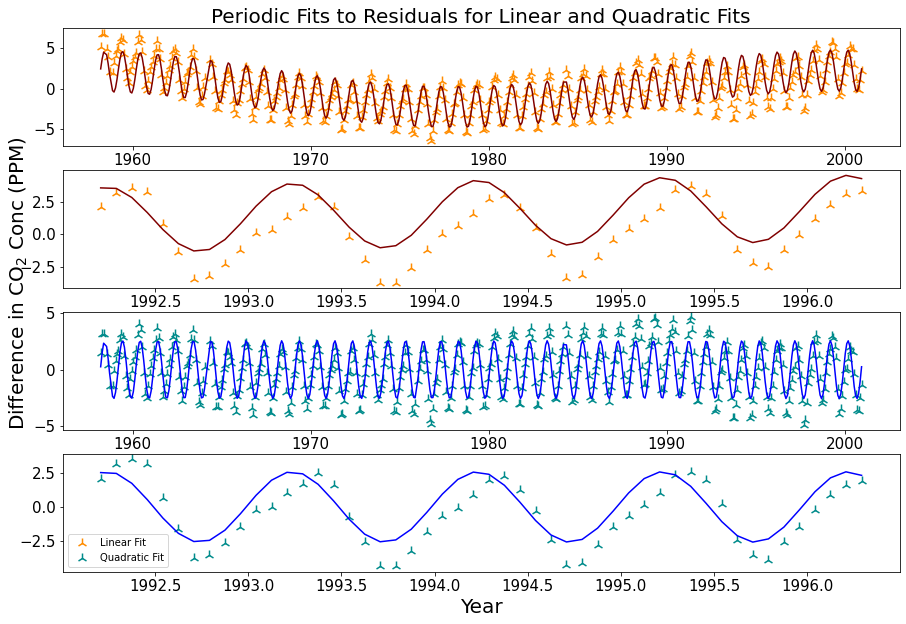

In [7]:
# add all sin and cos terms of each frequency multiplied by their corresponding coefficients to the residual fit
l_resfit = np.zeros(np.shape(x_tr))
for i in range(np.size(l_ws)):
    l_resfit = np.add(l_resfit, l_beta_sc[i]*np.sin(l_ws[i]*x_tr) + l_beta_sc[i+np.size(l_ws)]*np.cos(l_ws[i]*x_tr))

# repeat for quadratic residuals
q_resfit = np.zeros(np.shape(x_tr))
for i in range(np.size(q_ws)):
    q_resfit = np.add(q_resfit, q_beta_sc[i]*np.sin(q_ws[i]*x_tr) + q_beta_sc[i+np.size(q_ws)]*np.cos(q_ws[i]*x_tr))

plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

# plotting stuff
plt.subplot(411)
plt.title("Periodic Fits to Residuals for Linear and Quadratic Fits") 
top_scat = plt.scatter(x_tr, l_res, s=100, marker="2", color='darkorange', label='Linear Fit')
plt.plot(x_tr, l_resfit, color='maroon', label='Periodic Fit for Linear Residuals')

plt.subplot(412)
plt.scatter(x_tr[401:451], l_res[401:451], s=100, marker='2', color='darkorange') 
plt.plot(x_tr[401:451], l_resfit[401:451], color='maroon', label='Periodic Fit for Linear Residuals')

plt.subplot(413)
plt.ylabel('Difference in CO$_2$ Conc (PPM)', loc='bottom')
bot_scat = plt.scatter(x_tr, q_res, s=100, marker="2", color='darkcyan', label='Quadratic Fit')
plt.plot(x_tr, q_resfit, color='blue', label='Periodic Fit for Quadratic Residuals')

plt.subplot(414)
plt.scatter(x_tr[401:451], q_res[401:451], s=100, marker='2', color='darkcyan')
plt.plot(x_tr[401:451], q_resfit[401:451], color='blue', label='Periodic Fit for Quadratic Residuals')
plt.legend(handles=[top_scat, bot_scat])
plt.xlabel('Year')

plt.show()

### Combined Fits:

- Show scatter plots of data and combined fit for training data
- Show scatter plots of data and combined fit for all data
- Compare MSE and $R^2$ in the test data for each model, and determine which is the more suitable model

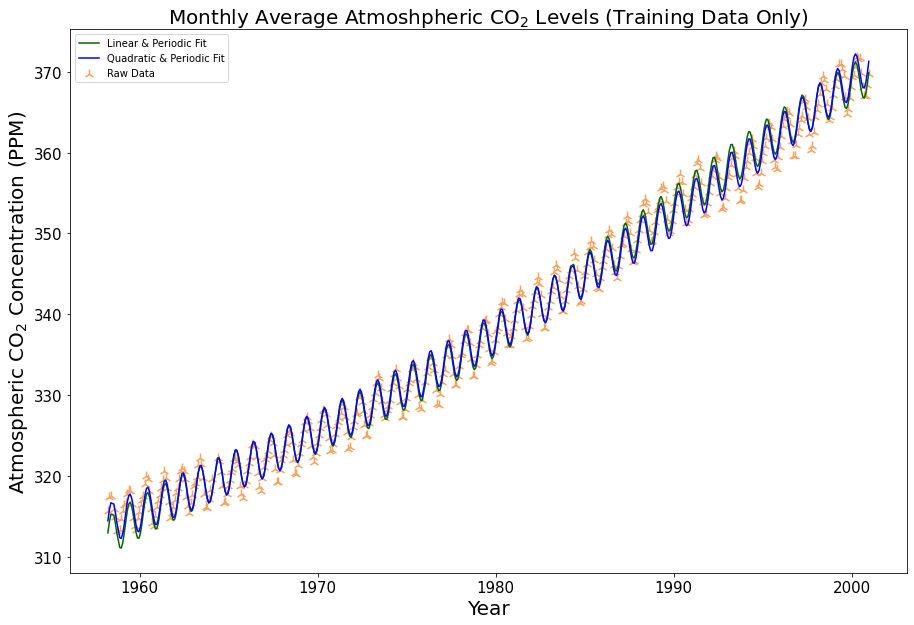

In [8]:
cl_fit = l_fit + l_resfit  # Combined linear fit
cq_fit = q_fit + q_resfit  # Combined quadratic fit

plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

plt.scatter(x_tr, y_tr, s=100, marker="2", color='sandybrown', label='Raw Data')
plt.plot(x_tr, cl_fit, color='darkgreen', label='Linear & Periodic Fit')
plt.plot(x_tr, cq_fit, color='blue', label='Quadratic & Periodic Fit')
plt.xlabel("Year")
plt.ylabel("Atmospheric CO$_2$ Concentration (PPM)")
plt.title("Monthly Average Atmoshpheric CO$_2$ Levels (Training Data Only)")
plt.legend()
plt.show()

In [9]:
i_test = np.size(x_tr)  # Index at which test data begins

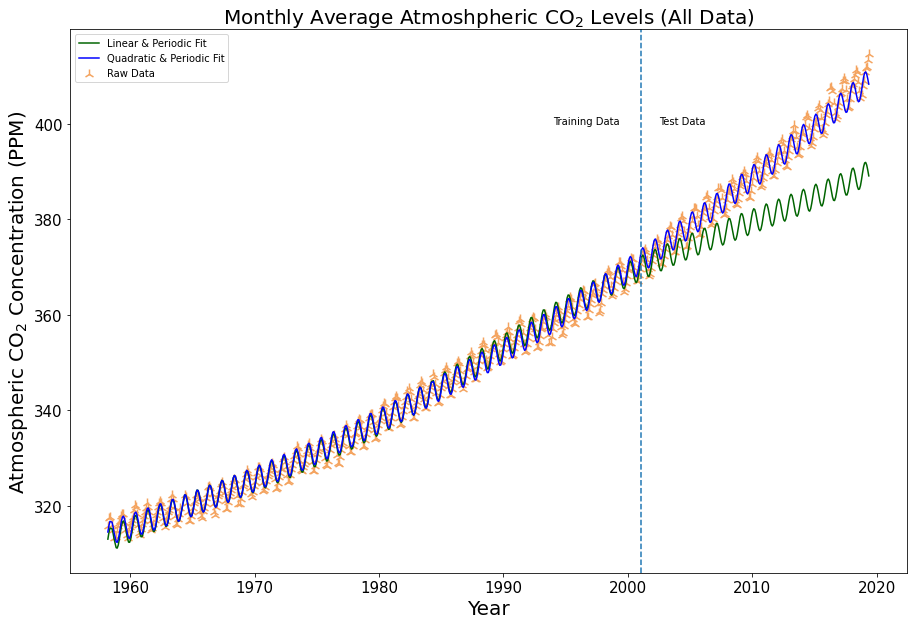

In [10]:
# split full data into x and y data
x_f = full_data[:,0]
y_f = full_data[:,1]

# Extend the models to the range of the full dataset
# Frequencies and coefficients are unchanged
X_lf = np.column_stack((tuple([x_f**i for i in range(2)])))
X_qf = np.column_stack((tuple([x_f**i for i in range(3)])))

# Linear and quadratic fits extended
lf_fit = X_lf.dot(beta_l)  
qf_fit = X_qf.dot(beta_q)

lf_resfit = np.zeros(np.shape(x_f))
for i in range(np.size(l_ws)):
    lf_resfit = np.add(lf_resfit, l_beta_sc[i]*np.sin(l_ws[i]*x_f) + l_beta_sc[i+np.size(l_ws)]*np.cos(l_ws[i]*x_f))

qf_resfit = np.zeros(np.shape(x_f))
for i in range(np.size(q_ws)):
    qf_resfit = np.add(qf_resfit, q_beta_sc[i]*np.sin(q_ws[i]*x_f) + q_beta_sc[i+np.size(q_ws)]*np.cos(q_ws[i]*x_f))

# Combined fits for full data
clf_fit = lf_fit + lf_resfit
cqf_fit = qf_fit + qf_resfit

plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

plt.scatter(x_f, y_f, s=100, marker="2", color='sandybrown', label='Raw Data')
plt.plot(x_f, clf_fit, color='darkgreen', label='Linear & Periodic Fit')
plt.plot(x_f, cqf_fit, color='blue', label='Quadratic & Periodic Fit')
plt.axvline(x_f[i_test], linestyle='--')
plt.text(2002.5, 400, "Test Data")
plt.text(1994, 400, "Training Data")
plt.xlabel("Year")
plt.ylabel("Atmospheric CO$_2$ Concentration (PPM)")
plt.title("Monthly Average Atmoshpheric CO$_2$ Levels (All Data)")
plt.legend()
plt.show()

In [11]:
# Split the test data into x and y data
x_t = test_data[:,0]
y_t = test_data[:,1]

# Get the models in the test data range only
# Could just use the tail end of the full data models, but just as easy to copy and paste code (though slower runtime)
X_lt = np.column_stack((tuple([x_t**i for i in range(2)])))
X_qt = np.column_stack((tuple([x_t**i for i in range(3)])))

lt_fit = X_lt.dot(beta_l) 
qt_fit = X_qt.dot(beta_q)

lt_resfit = np.zeros(np.shape(x_t))
for i in range(np.size(l_ws)):
    lt_resfit = np.add(lt_resfit, l_beta_sc[i]*np.sin(l_ws[i]*x_t) + l_beta_sc[i+np.size(l_ws)]*np.cos(l_ws[i]*x_t))

qt_resfit = np.zeros(np.shape(x_t))
for i in range(np.size(q_ws)):
    qt_resfit = np.add(qt_resfit, q_beta_sc[i]*np.sin(q_ws[i]*x_t) + q_beta_sc[i+np.size(q_ws)]*np.cos(q_ws[i]*x_t))

# Combined models for the test data
clt_fit = lt_fit + lt_resfit
cqt_fit = qt_fit + qt_resfit

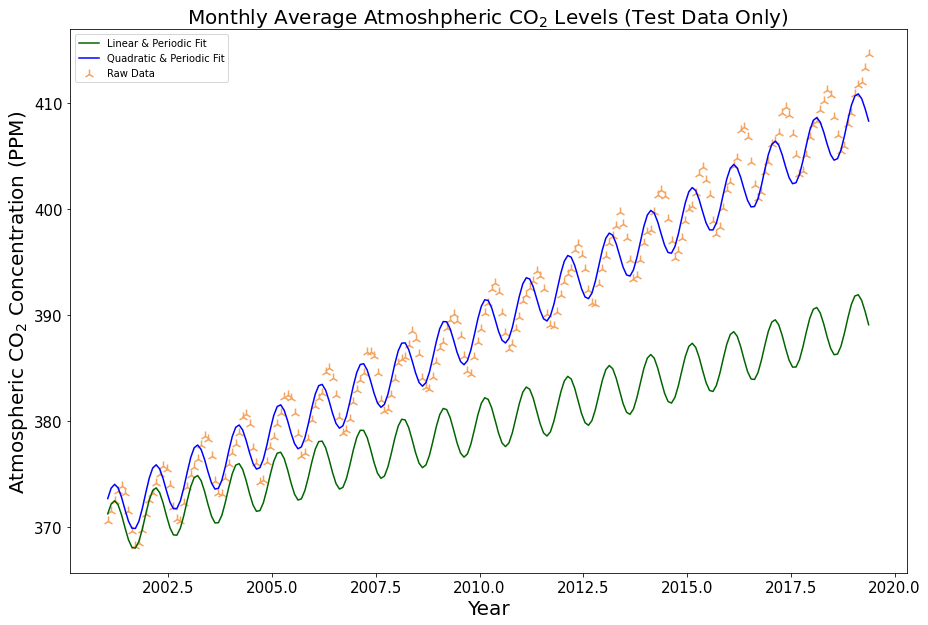

In [12]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

plt.scatter(x_t, y_t, s=100, marker="2", color='sandybrown', label='Raw Data')
plt.plot(x_t, clt_fit, color='darkgreen', label='Linear & Periodic Fit')
plt.plot(x_t, cqt_fit, color='blue', label='Quadratic & Periodic Fit')
plt.xlabel("Year")
plt.ylabel("Atmospheric CO$_2$ Concentration (PPM)")
plt.title("Monthly Average Atmoshpheric CO$_2$ Levels (Test Data Only)")
plt.legend()
plt.show()

In [13]:
# Compute relevant mean squared errors and coefficients of determination
yt_bar = np.sum(y_t) / np.size(y_t) # average y value in test range
sse_t0 = np.linalg.norm(y_t - yt_bar)**2 # sse for zeroth order polynomial model in test range

sse_tl = np.linalg.norm(y_t - clt_fit)**2 # sse for linear model in test range
mse_tl = sse_tl / np.size(x_t) # mse

sse_tq = np.linalg.norm(y_t - cqt_fit)**2 # sse for quadratic model in test range
mse_tq = sse_tq / np.size(x_t) # mse

r_sq_tl = 1 - sse_tl/sse_t0 # coeff of determination for linear model in test range
r_sq_tq = 1 - sse_tq/sse_t0 # coeff of determination for quadratic model in test range


yf_bar = np.sum(y_f) / np.size(y_f) # average y value in full range
sse_f0 = np.linalg.norm(y_f - yf_bar)**2 # sse for zeroth order polynomial model in full range

sse_fq = np.linalg.norm(y_f - cqf_fit)**2 # sse for quadratic model in full range
mse_fq = sse_fq / np.size(x_f) # mse
r_sq_fq = 1 - sse_fq/sse_f0 # coeff of determination for quad model in full range

print("\nCombined Linear Fit, Test Data \t\tMSE: ", np.round(mse_tl, 3), "\t\tR\u00B2: ", np.round(r_sq_tl, 3))
print("Combined Quadratic Fit, Test Data\tMSE: ", np.round(mse_tq, 3), "\t\tR\u00B2: ", np.round(r_sq_tq, 3))
print("\nCombined Quadratic Fit, Overall \tMSE: ", np.round(mse_fq, 3), "\t\tR\u00B2: ", np.round(r_sq_fq, 3))


Combined Linear Fit, Test Data 		MSE:  140.744 		R²:  -0.008
Combined Quadratic Fit, Test Data	MSE:  4.862 		R²:  0.965

Combined Quadratic Fit, Overall 	MSE:  2.527 		R²:  0.997


### Conclusion

- Clearly quadratic fit is better, with an $R^2$ value of 96.5% in the untrained data
- The negative $R^2$ for the linear fit indicates that in the test data the model performs worse than a horizontal line on the mean
- $CO_2$ levels rising in quadratic fashion, with yearly periodic fluctuations (likely due to changing seasons)